# Using ALBERT for Question Answering - SQuAD

Updates:

Things implemented:
- Data Loading
- Model
- Learner
- Prediction on new data
- Optimizer selection
- Segment IDs
- F1 Score
- Checkpoints
- Use a more powerful machine to train
- Gradient Accumulation
- Squad 2.0
    - Multi Task Learning Changes

TODO:
- Consider using the sliding window approach for long sequences


In [1]:
from src import *
from transformers import AutoTokenizer, AlbertModel,AlbertPreTrainedModel, PretrainedConfig
from pathlib import Path
import numpy as np
import pandas as pd
import json
import pickle
import re
import collections
from tqdm import tqdm, trange
from datetime import datetime
import logging
import os
import requests
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# logging.basicConfig()
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

In [5]:
config = Config(
    data_path = Path("../data/SQuAD/2.0"), # replace with the directory containing the parsed csv files
    output_dir = Path("./models"), # for storing model weights between epochs
    task = "SQuAD",
    squad_version = "2.0",
    testing=False,
    seed = 2020,
    model = 'albert-base-v2',
    max_lr=3e-5,
    max_lr_last = 1e-4,
    phases = .3,
    optimizer="lamb", # choose between 'adam' or 'lamb'
    epochs=2,
    use_fp16=False,
    recreate_ds=False,
    bs=4, 
    effective_bs=4, # set this different from bs to determine gradient accumulation steps (i.e. effective_bs/bs)
    max_seq_len=512,
    start_tok = "[CLS]",
    end_tok = "[SEP]",
    sep_tok = "[SEP]",
    unk_tok_idx=1,
    sep_idx=3,
    pad_idx=0,
    feat_cols = ["question","paragraph"],
    label_cols = ["idxs","is_impossible"],
    adjustment = 2,
    save_checkpoint = True,
    load_checkpoint=None,#"2020-02-02_23_32_09.566715-albert-base-v2-accuracy-0.62-epoch-0-squad_ver-2.0",
    model_parameters = Config(
        layer_norm_eps = 1e-12,
        num_labels_clas = 2,
        clas_dropout_prob = .1
    )
)

config.model_name = re.findall(r"(.+?)-",config.model)[0]
config.weights = config.output_dir/config.load_checkpoint if config.load_checkpoint else config.model 
r = requests.get(f"https://s3.amazonaws.com/models.huggingface.co/bert/{config.model}-config.json")
config.model_config = PretrainedConfig(**r.json(),**config.model_parameters)

# set optimizer
assert config.optimizer.lower() in ["adam","lamb"], f"invalid optimizer in config {config.optimizer}"
config.opt_func = lamb_opt() if config.optimizer.lower() == "lamb" else adam_opt()

## Utility Functions

In [6]:
def remove_max_sl(df):
    init_len = len(df)
    df = df[df.seq_len < config.max_seq_len-2]
    new_len = len(df)
    print(f"dropping {init_len - new_len} out of {init_len} questions")
    return df

def str2tensor(s):
    indices = re.findall("-?\d+",s)
    return torch.tensor([int(indices[0]), int(indices[1])], dtype=torch.long)

def set_segments(x,sep_idx=config.sep_idx):
    res = x.new_zeros(x.size())
    for row_idx, row in enumerate(x):
        in_seg_1 = False
        for val_idx,val in enumerate(row):
            if val == sep_idx:
                in_seg_1 = True
            if in_seg_1: 
                res[row_idx,val_idx] = 1
    return res

# Loading the data

In [7]:
train = pd.read_csv(config.data_path/f"train_{config.squad_version}_{config.model_name}.csv")
valid = pd.read_csv(config.data_path/f"val_{config.squad_version}_{config.model_name}.csv")

In [8]:
train.drop_duplicates(inplace=True)
valid.drop_duplicates(inplace=True)

In [9]:
# randomizing the order of training data
train = train.sample(frac=1).reset_index(drop=True) #random_state = config.seed
valid = valid.sample(frac=1).reset_index(drop=True)

In [10]:
train.is_impossible.value_counts(normalize=True), valid.is_impossible.value_counts(normalize=True)

(False    0.66617
 True     0.33383
 Name: is_impossible, dtype: float64, False    0.636592
 True     0.363408
 Name: is_impossible, dtype: float64)

(False    0.66617
 True     0.33383
 Name: is_impossible, dtype: float64, False    0.636592
 True     0.363408
 Name: is_impossible, dtype: float64)

In [11]:
# reduce df sizes if testing
if config.testing:
    train = train[:int(len(train)/20)]
    valid = valid[:int(len(valid)/20)]

In [12]:
train, valid = remove_max_sl(train), remove_max_sl(valid)

dropping 216 out of 130294 questions
dropping 124 out of 16315 questions
dropping 216 out of 130294 questions
dropping 124 out of 16315 questions


In [13]:
# train["idxs"] = train.apply(lambda row: row["idxs"] if not row["is_impossible"] else '[-2, -2]',axis=1)
# valid["idxs"] = valid.apply(lambda row: row["idxs"] if not row["is_impossible"] else '[-2, -2]',axis=1)

In [14]:
train.head()

,question,paragraph,answer,idxs,seq_len,ans_text,is_impossible
0,When was the southern tip of Africa colonized?,The Dutch East India Company had founded the C...,"['▁16', '52']","[27, 29]",260,1652,False
1,Who did Elizabeth appoint as Prime Minister af...,The Suez crisis and the choice of Eden's succe...,"['▁earl', '▁of', '▁home']","[101, 104]",162,Earl of Home,False
2,Where are archival descriptions of holdings un...,Archival descriptions of the permanent holding...,"['▁archival', '▁research', '▁catalog', '▁', '(...","[31, 38]",98,Archival Research Catalog (ARC),False
3,The torque amplifiers of the differential anal...,The art of mechanical analog computing reached...,"['▁h', '.', '▁w', '.', '▁', 'nie', 'man']","[66, 73]",89,H. W. Nieman,False
4,"Due to low waer tariffs, what is required to m...",Partly because of low sanitation coverage abou...,"['▁government', '▁subsidies']","[61, 63]",111,government subsidies,False


,question,paragraph,answer,idxs,seq_len,ans_text,is_impossible
0,When was the southern tip of Africa colonized?,The Dutch East India Company had founded the C...,"['▁16', '52']","[27, 29]",260,1652,False
1,Who did Elizabeth appoint as Prime Minister af...,The Suez crisis and the choice of Eden's succe...,"['▁earl', '▁of', '▁home']","[101, 104]",162,Earl of Home,False
2,Where are archival descriptions of holdings un...,Archival descriptions of the permanent holding...,"['▁archival', '▁research', '▁catalog', '▁', '(...","[31, 38]",98,Archival Research Catalog (ARC),False
3,The torque amplifiers of the differential anal...,The art of mechanical analog computing reached...,"['▁h', '.', '▁w', '.', '▁', 'nie', 'man']","[66, 73]",89,H. W. Nieman,False
4,"Due to low waer tariffs, what is required to m...",Partly because of low sanitation coverage abou...,"['▁government', '▁subsidies']","[61, 63]",111,government subsidies,False


# Setting up the Tokenizer

In [15]:
class TokenizerProcessor(Processor):
    def __init__(self, tok_func, max_sl, start_tok, end_tok, pre_rules=None,post_rules=None):
        self.tok_func,self.max_sl = tok_func,max_sl
        self.pre_rules,self.post_rules=pre_rules,post_rules
        self.start_tok, self.end_tok = start_tok, end_tok

    def proc1(self, x): return [self.start_tok] + self.tok_func(x)[:self.max_sl-2] + [self.end_tok]
    
    def __call__(self, items): return tqdm([self.proc1(x) for x in items])

class NumericalizeProcessor(Processor):
    """
    only works with an existing vocab at the moment and min_freq is not accounted for
    """
    def __init__(self, vocab:dict, unk_tok_idx:int, min_freq=2): 
        self.vocab, self.unk_tok_idx, self.min_freq = vocab, unk_tok_idx, min_freq
    
    def proc1(self, x): return [self.vocab[i] if i in self.vocab else self.unk_tok_idx for i in x]
    
    def __call__(self, items): 
        if getattr(self, 'otoi', None) is None:
            self.otoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.vocab)})
        return tqdm([self.proc1(x) for x in items])

In [16]:
tok = AutoTokenizer.from_pretrained(config.model)
proc_tok = TokenizerProcessor(tok.tokenize, config.max_seq_len, config.start_tok, config.end_tok)

In [17]:
vocab = {tok.convert_ids_to_tokens(i):i for i in range(tok.vocab_size)}
proc_num = NumericalizeProcessor(vocab, unk_tok_idx=config.unk_tok_idx)

In [18]:
class QALabelProcessor(Processor):
    def __init__(self, parse_func = noop, adjustment = 2):
        self.parse_func = parse_func
        self.adjustment = adjustment
        self.vocab=[False, True]
        self.otoi=None
        
    def cat_proc1(self,item): return self.otoi[item]
    def index_proc1(self, item): return self.parse_func(item) + self.adjustment
    
    def __call__(self, items): 
        if self.otoi is None:
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [(self.index_proc1(item[0]),self.cat_proc1(item[1])) for item in items] # we want the 
    

In [19]:
proc_qa = QALabelProcessor(str2tensor,config.adjustment)

In [20]:
class SquadTextList(ItemList):      
    @classmethod  
    def from_df(cls, df, feat_cols, label_cols, sep_tok, test=False):
        feat_cols = listify(feat_cols)
        x = df[feat_cols[0]]
        for i in range(1,len(feat_cols)):
            x += f" {sep_tok} " + df[feat_cols[i]]
        labels = cls(df[label_cols].values) if not test else cls([[None,None] for _ in len(df)])
        return cls(x,labels=labels)

In [21]:
if (not (config.data_path/f"squad_{config.squad_version}_data_trn.pkl").exists()) or config.recreate_ds or config.testing:
    il_train = SquadTextList.from_df(train,config.feat_cols,config.label_cols,config.sep_tok)
    il_valid = SquadTextList.from_df(valid,config.feat_cols,config.label_cols,config.sep_tok)

    ll_valid = LabeledData(il_valid,il_valid.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])
    ll_train = LabeledData(il_train,il_train.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])

    # saving/loading presaved data if not testing
    if not config.testing:
        # save an object
        pickle.dump(ll_train, open( config.data_path/f"squad_{config.squad_version}_data_trn.pkl", "wb" ) )
        pickle.dump(ll_valid, open( config.data_path/f"squad_{config.squad_version}_data_val.pkl", "wb" ) )
else:
    # load an object
    ll_train = pickle.load( open( config.data_path/f"squad_{config.squad_version}_data_trn.pkl", "rb" ) )
    ll_valid = pickle.load( open( config.data_path/f"squad_{config.squad_version}_data_val.pkl", "rb" ) )

In [22]:
from torch.utils.data import Sampler

class SortSampler(Sampler):
    def __init__(self, data_source, key): self.data_source,self.key = data_source,key
    def __len__(self): return len(self.data_source)
    def __iter__(self):
        return iter(sorted(list(range(len(self.data_source))), key=self.key, reverse=True))

In [23]:
class SortishSampler(Sampler):
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = torch.randperm(len(self.data_source))
        megabatches = [idxs[i:i+self.bs*50] for i in range(0, len(idxs), self.bs*50)]
        sorted_idx = torch.cat([tensor(sorted(s, key=self.key, reverse=True)) for s in megabatches])
        batches = [sorted_idx[i:i+self.bs] for i in range(0, len(sorted_idx), self.bs)]
        max_idx = torch.argmax(tensor([self.key(ck[0]) for ck in batches]))  # find the chunk with the largest key,
        batches[0],batches[max_idx] = batches[max_idx],batches[0]            # then make sure it goes first.
        batch_idxs = torch.randperm(len(batches)-2)
        sorted_idx = torch.cat([batches[i+1] for i in batch_idxs]) if len(batches) > 1 else LongTensor([])
        sorted_idx = torch.cat([batches[0], sorted_idx, batches[-1]])
        return iter(sorted_idx)

In [24]:
def pad_collate_qa(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    qa_idxs = torch.cat([s[1][0].unsqueeze(0) for s in samples])
    imp_labels = torch.tensor([s[1][1] for s in samples])
    return res, (qa_idxs, imp_labels)

In [25]:
train_sampler = SortishSampler(ll_train.x, key=lambda t: len(ll_train[int(t)][0]), bs=config.bs)
train_dl = DataLoader(ll_train, batch_size=config.bs, sampler=train_sampler, collate_fn=pad_collate_qa)

valid_sampler = SortSampler(ll_valid.x, key=lambda t: len(ll_valid[int(t)][0]))
valid_dl = DataLoader(ll_valid, batch_size=config.bs, sampler=valid_sampler, collate_fn=pad_collate_qa)

In [26]:
# x,y = next(iter(train_dl))

# Setting up the Databunch

In [27]:
data = DataBunch(train_dl,valid_dl)

# Defining Model

## Base QA Model

In [28]:
class AlbertForQuestionAnswering(AlbertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.albert = AlbertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`).
            Position outside of the sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`).
            Position outside of the sequence are not taken into account for computing the loss.
    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.AlbertConfig`) and inputs:
        loss: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Total span extraction loss is the sum of a Cross-Entropy for the start and end positions.
        start_scores ``torch.FloatTensor`` of shape ``(batch_size, sequence_length,)``
            Span-start scores (before SoftMax).
        end_scores: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length,)``
            Span-end scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    Examples::
        # The checkpoint albert-base-v2 is not fine-tuned for question answering. Please see the
        # examples/run_squad.py example to see how to fine-tune a model to a question answering task.
        from transformers import AlbertTokenizer, AlbertForQuestionAnswering
        import torch
        tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
        model = AlbertForQuestionAnswering.from_pretrained('albert-base-v2')
        question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
        input_dict = tokenizer.encode_plus(question, text, return_tensors='pt')
        start_scores, end_scores = model(**input_dict)
        """

        outputs = self.albert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output, pooled_output = outputs[:2]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits,) + outputs[2:]
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            outputs = (total_loss,) + outputs

        return outputs + (pooled_output,)  # (loss), start_logits, end_logits, (hidden_states), (attentions)

## Custom MTL Model

In [29]:
class AlbertForQuestionAnsweringMTL(nn.Module):
    def __init__(self, config):
        super(AlbertForQuestionAnsweringMTL,self).__init__()
        m_config = config.model_config # this config contains the model specific parameters
        self.bert = AlbertForQuestionAnswering(m_config) if config.load_checkpoint else\
        AlbertForQuestionAnswering.from_pretrained(config.model)
        self.bert.train()
        self.poss_drop = nn.Dropout(m_config.clas_dropout_prob)
        self.poss = nn.Linear(m_config.hidden_size,m_config.num_labels_clas)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):       
        token_type_ids = set_segments(input_ids)
        outputs = self.bert(input_ids,token_type_ids=token_type_ids)
        poss_outputs = self.poss_drop(self.poss(outputs[2]))
        return outputs[:2] + (poss_outputs,)

In [30]:
model = AlbertForQuestionAnsweringMTL(config)
if config.load_checkpoint:
    st = torch.load(config.output_dir/config.load_checkpoint/"weights.bin")
    learn.model.load_state_dict(st)

# Loss Function and Evaluation Metrics

In [31]:
def assert_no_negs(tensor):
    assert torch.all(torch.eq(tensor, abs(tensor)))

In [32]:
# defining the loss function
# defining the loss function
def cross_entropy_qa_mtl(input, target):
    """
    Summing the cross entropy loss from the starting and ending indices. 
    """
    loss = torch.add(F.cross_entropy(input[0], target[0][:,0]) , F.cross_entropy(input[1], target[0][:,1]))
    poss_loss = F.cross_entropy(input[2], target[1])
    return torch.add(loss, poss_loss)

# def cross_entropy_qa_mtl(input, target):
#     """
#     Summing the cross entropy loss from the starting and ending indices. 
#     """
#     assert_no_negs(target[0])
#     assert_no_negs(target[1])
    
#     mask = (~target[1].bool()).float()
#     qa_loss = torch.add(F.cross_entropy(input[0], target[0][:,0], reduction="none"),\
#                         F.cross_entropy(input[1], target[0][:,1], reduction="none"))/2.0
#     qa_loss.mul_(mask+1)
#     wtd_qa_loss = qa_loss.mean()

#     imp_loss = F.cross_entropy(input[2], target[1])
    
#     loss = torch.add(wtd_qa_loss, imp_loss)
#     return loss

In [33]:
# defining the evaluation metrics based on squad evaluation method
def acc_qa(input,target,xb):
    """
    Taking the average between the accuracies of predicting the start and ending indices
    """
    return (accuracy(input[0], target[0][:,0]) + accuracy(input[1], target[0][:,1]))/2.0

def acc_imp(input,target,xb):
    return accuracy(input[2], target[1])

def exact_match(input,target,xb):
    def _acc(out, yb): return (torch.argmax(out, dim=1)==yb).float()
    return (_acc(input[0], target[0][:,0]) + _acc(input[1], target[0][:,1]) == 2).float().mean()

In [34]:
def f1_score(input,target,xb):
    """
    based on the official evaluation script:
    https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
    """
    pred_starts,pred_ends = [torch.argmax(out, dim=1) for out in input[:2]]
    gold_starts,gold_ends = target[0][:,0], target[0][:,1]
    
    def _get_toks(idx,start,end):
        if start == end: end += 1
        return xb[idx][start:end]
    
    def _score1(pred_toks,gold_toks):
        common = collections.Counter(gold_toks.tolist()) & collections.Counter(pred_toks.tolist())
        num_same = sum(common.values())
        if num_same == 0: 
            return 0
        precision = 1.0 * num_same / len(pred_toks)
        recall = 1.0 * num_same / len(gold_toks)
        f1 = (2 * precision * recall) / (precision + recall)
        return f1
    
    pred_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(pred_starts,pred_ends))]
    gold_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(gold_starts,gold_ends))]
    score = np.mean([_score1(pred,gold) for pred,gold in zip(pred_toks,gold_toks)])
    return score             

# Callbacks

In [35]:
def save_model(learner,output_dir: Path):
    def _create_dir(dirc):
        if not os.path.exists(dirc): os.mkdir(dirc)
    epoch = learner.epoch
    metric = round(float(learner.qa_avg_stats.valid_stats.avg_stats[1]),2)
    _create_dir(output_dir)
    model_dir = f"{re.sub(r'[ :]+','_',str(datetime.now()))}-{config.model}-accuracy-{metric}-epoch-{epoch}-squad_ver-{config.squad_version}"
    _create_dir(output_dir/model_dir)
    st = learner.model.state_dict()
    logging.info(f"saving model in {output_dir/model_dir}")
    torch.save(st,output_dir/model_dir/"weights.bin") 

class SaveModelCallback(Callback):
    def __init__(self,save_model_func,output_dir):
        self.output_dir, self.save_model_func = output_dir,save_model_func
    def after_epoch(self):
        self.save_model_func(self, self.output_dir)        

In [36]:
class CudaCallbackMTL(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = \
        self.xb.cuda(), (self.run.yb[0].cuda(), self.run.yb[1].cuda())

In [37]:
# gradient accumulation
class GradientAccumulation(Callback):
    _order=2
    def __init__(self,bs,effective_bs):
        self.bs, self.effective_bs = bs, effective_bs
    def after_loss(self):
        self.loss.div_(self.effective_bs/self.bs)
    def after_backward(self):
        if self.n_iter*self.bs % self.effective_bs != 0: raise CancelBatchException()

In [38]:
class QAAvgStats(AvgStats):
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb, run.xb) * bn
            
class QAAvgStatsCallback(AvgStatsCallback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = QAAvgStats(metrics,True),QAAvgStats(metrics,False)

In [39]:
class TrainStatsCallback(Callback):
    _order=5
    def __init__(self, update_freq_pct=.05):
        self.update_freq_pct = update_freq_pct
        logging.basicConfig()
        self.logger = logging.getLogger()
        self.logger.setLevel(logging.INFO)
        
    def begin_epoch(self):
        self.iter = 0
        self.update_freq = int(self.update_freq_pct*len(self.dl))
        
    def after_batch(self):
        if not self.in_train: return 
        self.iter += 1
        if self.n_iter % self.update_freq == 0:
            stats = learn.qa_avg_stats.train_stats 
            self.logger.info(f"epoch {self.epoch} stats for {self.iter} out of {self.iters} are : {stats}")

In [40]:
cbfs = [partial(QAAvgStatsCallback,[acc_qa,acc_imp,exact_match]),#,exact_match,,f1_score]),
        CudaCallbackMTL,
        ProgressCallback,
        Recorder,
        TrainStatsCallback]

if not config.testing and config.save_checkpoint: 
    cbfs.append(partial(SaveModelCallback,save_model,config.output_dir))
    
if config.effective_bs and config.bs != config.effective_bs:
    cbfs.append(partial(GradientAccumulation,config.bs,config.effective_bs))

# Splitter

In [41]:
def albert_splitter(m, g1=[],g2=[]):
    l = list(dict(m.named_children()).keys())
    if "qa_outputs" in  l: g2+= m.qa_outputs.parameters()
    if "imp_outputs" in l: g2+= m.imp_outputs.parameters()
    if isinstance(m,torch.nn.modules.normalization.LayerNorm):
        g1+= m.parameters()
    elif hasattr(m, 'weight'): 
        g1+= m.parameters()
    for ll in m.children(): albert_splitter(ll, g1, g2)
    return g1,g2

# LR Scheduling

In [42]:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11_train_imagenette.ipynb
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11a_transfer_learning.ipynb
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

disc_lr_sched = sched_1cycle([config.max_lr,config.max_lr_last], config.phases) 

In [43]:
# the learning rate we apply here does not matter since we are scheduling 
learn = Learner(model, data, cross_entropy_qa_mtl,lr=config.max_lr,cb_funcs=cbfs,splitter=albert_splitter\
                ,opt_func=config.opt_func)

In [44]:
learn.fit(config.epochs,cbs=disc_lr_sched)

epoch,train_loss,train_acc_qa,train_acc_imp,train_exact_match,valid_loss,valid_acc_qa,valid_acc_imp,valid_exact_match,time
0,3.080513,0.644321,0.786159,0.512200,3.203301,0.609968,0.809400,0.458650,2:47:51
1,1.983269,0.743392,0.883408,0.624564,3.032758,0.620499,0.850473,0.467791,2:48:09


epoch,train_loss,train_acc_qa,train_acc_imp,train_exact_match,valid_loss,valid_acc_qa,valid_acc_imp,valid_exact_match,time
0,3.080513,0.644321,0.786159,0.512200,3.203301,0.609968,0.809400,0.458650,2:47:51
1,1.983269,0.743392,0.883408,0.624564,3.032758,0.620499,0.850473,0.467791,2:48:09


INFO:root:epoch 0 stats for 1626 out of 32520 are : train: [8.309704244503383, tensor(0.1681, device='cuda:0'), tensor(0.6328, device='cuda:0'), tensor(0.0624, device='cuda:0')]
INFO:root:epoch 0 stats for 1626 out of 32520 are : train: [8.309704244503383, tensor(0.1681, device='cuda:0'), tensor(0.6328, device='cuda:0'), tensor(0.0624, device='cuda:0')]
INFO:root:epoch 0 stats for 3252 out of 32520 are : train: [6.414985009225092, tensor(0.3399, device='cuda:0'), tensor(0.6395, device='cuda:0'), tensor(0.2086, device='cuda:0')]
INFO:root:epoch 0 stats for 3252 out of 32520 are : train: [6.414985009225092, tensor(0.3399, device='cuda:0'), tensor(0.6395, device='cuda:0'), tensor(0.2086, device='cuda:0')]
INFO:root:epoch 0 stats for 4878 out of 32520 are : train: [5.526458077080771, tensor(0.4224, device='cuda:0'), tensor(0.6505, device='cuda:0'), tensor(0.2841, device='cuda:0')]
INFO:root:epoch 0 stats for 4878 out of 32520 are : train: [5.526458077080771, tensor(0.4224, device='cuda:0')

INFO:root:epoch 1 stats for 17886 out of 32520 are : train: [2.0338078664877557, tensor(0.7388, device='cuda:0'), tensor(0.8790, device='cuda:0'), tensor(0.6179, device='cuda:0')]
INFO:root:epoch 1 stats for 19512 out of 32520 are : train: [2.0279303281314065, tensor(0.7394, device='cuda:0'), tensor(0.8791, device='cuda:0'), tensor(0.6188, device='cuda:0')]
INFO:root:epoch 1 stats for 21138 out of 32520 are : train: [2.023479449037279, tensor(0.7397, device='cuda:0'), tensor(0.8798, device='cuda:0'), tensor(0.6193, device='cuda:0')]
INFO:root:epoch 1 stats for 22764 out of 32520 are : train: [2.016959686895976, tensor(0.7405, device='cuda:0'), tensor(0.8804, device='cuda:0'), tensor(0.6210, device='cuda:0')]
INFO:root:epoch 1 stats for 24390 out of 32520 are : train: [2.0098276060885607, tensor(0.7410, device='cuda:0'), tensor(0.8809, device='cuda:0'), tensor(0.6214, device='cuda:0')]
INFO:root:epoch 1 stats for 26016 out of 32520 are : train: [2.004385372222863, tensor(0.7413, device=

In [45]:
learn.qa_avg_stats.train_stats

train: [1.9832691731115177, tensor(0.7434, device='cuda:0'), tensor(0.8834, device='cuda:0'), tensor(0.6246, device='cuda:0')]

In [46]:
learn.qa_avg_stats.valid_stats

valid: [3.032757637344821, tensor(0.6205, device='cuda:0'), tensor(0.8505, device='cuda:0'), tensor(0.4678, device='cuda:0')]

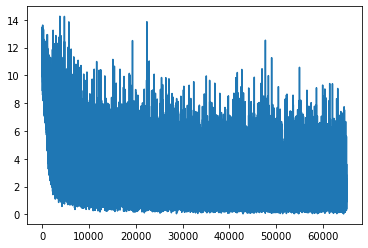

In [47]:
learn.recorder.plot_loss()

In [48]:
# manually save and load model weights

# save_model(learn,config.output_dir)
# learn.model.load_state_dict(torch.load(config.output_dir/config.load_checkpoint/"weights.bin"))

# Predictions

In [49]:
def get_raw_preds(learner):
    learner("begin_epoch")
    with torch.no_grad(): 
        learner.dl = learner.data.valid_dl
        yps = []
        ybs = []
        for i,(xb,yb) in enumerate(tqdm(learner.dl)):
            learner.iter = i
            learner.xb,learner.yb = xb,yb                      
            learner('begin_batch')
            ybs.append(yb)
            yps.append(learner.model(learner.xb))
    return yps, ybs

yps,ybs = get_raw_preds(learn)

preds = [(torch.stack([torch.argmax(si,1),torch.argmax(ei,1)],1),torch.argmax(poss,1)) for (si,ei,poss) in yps]

p1,p2 = zip(*preds)

p1,p2 = torch.cat(p1),torch.cat(p2)

a1,a2 = zip(*ybs)
a1,a2 = torch.cat(a1),torch.cat(a2)

print(f"accuracy for detecting {(a2.cuda()==p2).float().mean()}"

p1.shape

p1[~a2.bool()]

(  ((p1[:,0] == a1[:,0].cuda()).float().mean()) + ((p1[:,1] == a1[:,1].cuda()).float().mean()))/2

In [60]:
def pad_collate_x(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    return res

def prep_text(text, question, tok):
    tok_text, tok_ques = tok.tokenize(text), tok.tokenize(question) 
    truncate_len = 512 - len(tok_ques) - 3*3
    res = ["[CLS]"] + tok_text[:truncate_len] + ["[SEP]"] + tok_ques + ["[SEP]"]
    return torch.tensor(tok.convert_tokens_to_ids(res)).unsqueeze(0)

def get_pred(texts, question, model, tok):
    if texts == []: return "could not find a section which matched query","N/A"
    texts = listify(texts)
    # 1. tokenize/encode the input text
    input_ids = pad_collate_x([prep_text(t, question, tok) for t in texts])
    # 2. extract the logits vector for the next possible token
    outputs = model(input_ids.cuda())
    logits,imp_logits = outputs[:2],outputs[2]
    # 3. apply argmax to the logits so we have the probabilities of each index 
    (start_probs,starts),(end_probs,ends) = [torch.max(out, dim=1) for out in logits]
    # 4. sort the sums of the starts and ends to determine which answers are the most ideal
    sorted_sums = np.argsort([sp+ep for (sp,ep) in zip(start_probs,end_probs)])[::-1]
    answerable = bool(torch.argmax(imp_logits,dim=1))
    def _proc1(idx,start,end):
        if start > end: return
        elif start == end: end += 1
        pred = tok.convert_ids_to_tokens(input_ids[idx][start:end])
        return tok.convert_tokens_to_string(pred)
    
    # find the best answer
    for i,s in enumerate(sorted_sums):
        ans = _proc1(i,starts[i],ends[i])
        if ans is not None and "<pad>" not in ans: return answerable, ans, texts[i]
    return "unanswerable",texts[i]

In [61]:
# tests with samples 
sample1 = "[CLS] there have been thirty earthquakes in the past three days. [SEP] how many earthquakes have there been? [SEP]"
sample2 = "[CLS] the storm took place yesterday from dawn to dusk [SEP] what took place??"
sample3 = "[CLS] No.2 pencils are used a lot in schools. [SEP] what are used?"

In [62]:
get_pred([sample1],"",learn.model,tok)

(False,
 'thirty',
 '[CLS] there have been thirty earthquakes in the past three days. [SEP] how many earthquakes have there been? [SEP]')